## Gensim Modeling
---

In [1]:
# Basic Imports
import nltk
import re
import numpy as np
import pandas as pd

# Import spaCy for Lemmatization
import spacy

# Gensim for Topic Modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting Tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

# Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from pprint import pprint

%matplotlib inline

unable to import 'smart_open.gcs', disabling that module


### Import Client News Data
---

In [49]:
df = pd.read_csv('client_sentiment_3.csv')
df = df.drop('Unnamed: 0', axis=1)
print(df.Client.unique())
cba_df = df[df.Client=='CBA']
cba_df.head()

['CBA' 'NAB' 'Westpac' 'ANZ']


,Client,Date,Headline,Source,VADER Score,neg,neu,pos
0,CBA,2020-03-24,Business orders crash on coronavirus: CBA index,The Australian Financial Review,-0.4019,0.31,0.690,0.000
1,CBA,2020-04-16,"Sydney, Melbourne house prices facing 10 per c...",Brisbane Times,0.0000,0.00,1.000,0.000
2,CBA,2020-04-14,Hoarding boom is over: CBA says shoppers have ...,The Age,0.0000,0.00,1.000,0.000
3,CBA,2020-03-31,Coronavirus: CBA report reveals what we’re buy...,NEWS.com.au,0.0000,0.00,1.000,0.000
4,CBA,2020-04-01,CBA increases coronavirus loan support,7NEWS.com.au,0.4019,0.00,0.597,0.403


### Prepare Stopwords
---

In [50]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from','subject','re','edu','use'])

In [72]:
# Convert to list
# data = cba_df['Headline'].values.tolist()
data = df['Headline'].values.tolist()
# Remove new line characters
data = [re.sub('\s+',' ',sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\''","",sent) for sent in data]
pprint(data[:1])

['Business orders crash on coronavirus: CBA index ']


### Tokenization
----
1. Break down each sentence into a list of words
2. Bag of Words model

In [73]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True remove punctuation
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))
print(data_words[:1])

[['business', 'orders', 'crash', 'on', 'coronavirus', 'cba', 'index']]


### Bi-gram and Tri-grams
---
Two-words or three-words frequently occurring together

In [74]:
# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

In [75]:
# Get a sentence clubbed as a bigram/trigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [76]:
# Trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['sydney', 'melbourne', 'house', 'prices', 'facing', 'per', 'cent', 'fall', 'cba']


### Define functions for stopwords, bigrams, trigrams and lemmatization
---

In [77]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [78]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [79]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [80]:
def lemmatization(texts, allow_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allow_postags])
    return texts_out

In [81]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
print(data_words_nostops[:5])

[['business', 'orders', 'crash', 'coronavirus', 'cba', 'index'], ['sydney', 'melbourne', 'house', 'prices', 'facing', 'per', 'cent', 'fall', 'cba'], ['hoarding', 'boom', 'cba', 'says', 'shoppers', 'closed', 'wallets'], ['coronavirus', 'cba', 'report', 'reveals', 'buying', 'pandemic'], ['cba', 'increases', 'coronavirus', 'loan', 'support']]


In [82]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_bigrams[:5])

[['business', 'orders', 'crash', 'coronavirus', 'cba', 'index'], ['sydney', 'melbourne', 'house', 'prices', 'facing', 'per', 'cent', 'fall', 'cba'], ['hoarding', 'boom', 'cba', 'says', 'shoppers', 'closed', 'wallets'], ['coronavirus', 'cba', 'report', 'reveals', 'buying', 'pandemic'], ['cba', 'increases', 'coronavirus', 'loan', 'support']]


In [83]:
# Do lemmatization keeping only nouns, adj, vb adv
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allow_postags=['NOUN','ADJ','VERB','ADV'])
print(data_lemmatized[:5])

[['business', 'order', 'crash', 'coronavirus', 'cba', 'index'], ['sydney', 'melbourne', 'house', 'price', 'face', 'cent', 'fall', 'cba'], ['hoard', 'boom', 'cba', 'say', 'shopper', 'close', 'wallet'], ['coronavirus', 'cba', 'report', 'reveal', 'buy', 'pandemic'], ['cba', 'increase', 'coronavirus', 'loan', 'support']]


### Create a Dictionary and Corpus for Topic Modeling
---

In [84]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Word id 0 occurs once in the first doc
# Word id 1 occurs once in the first doc
# Word id 2 occurs once in the first doc

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [85]:
id2word[0]

'business'

In [86]:
# Human readable format of corpus (term-freq)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('business', 1),
  ('cba', 1),
  ('coronavirus', 1),
  ('crash', 1),
  ('index', 1),
  ('order', 1)],
 [('cba', 1),
  ('cent', 1),
  ('face', 1),
  ('fall', 1),
  ('house', 1),
  ('melbourne', 1),
  ('price', 1),
  ('sydney', 1)],
 [('cba', 1),
  ('boom', 1),
  ('close', 1),
  ('hoard', 1),
  ('say', 1),
  ('shopper', 1),
  ('wallet', 1)],
 [('cba', 1),
  ('coronavirus', 1),
  ('buy', 1),
  ('pandemic', 1),
  ('report', 1),
  ('reveal', 1)],
 [('cba', 1),
  ('coronavirus', 1),
  ('increase', 1),
  ('loan', 1),
  ('support', 1)]]

In [87]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=123,
                                           update_every=1,
                                           chunksize=40,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model
---

In [88]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"price" + 0.033*"analyst" + 0.031*"property" + 0.029*"increase" + '
  '0.024*"fall" + 0.023*"jone" + 0.018*"jump" + 0.017*"give" + 0.017*"drop" + '
  '0.017*"profit"'),
 (1,
  '0.091*"coronavirus" + 0.075*"westpac" + 0.057*"nab" + 0.038*"job" + '
  '0.028*"new" + 0.025*"cba" + 0.022*"unemployment" + 0.019*"consumer" + '
  '0.018*"face" + 0.017*"fall"'),
 (2,
  '0.096*"anz" + 0.047*"say" + 0.022*"help" + 0.022*"sale" + 0.016*"financial" '
  '+ 0.015*"tumble" + 0.015*"still" + 0.012*"place" + 0.012*"retail" + '
  '0.012*"league"'),
 (3,
  '0.142*"covid" + 0.088*"australia" + 0.031*"rent" + 0.023*"know" + '
  '0.019*"announce" + 0.018*"death" + 0.017*"netball" + 0.017*"expert" + '
  '0.015*"everything" + 0.015*"live"'),
 (4,
  '0.051*"customer" + 0.036*"month" + 0.028*"impact" + 0.027*"rise" + '
  '0.025*"take" + 0.024*"economy" + 0.022*"urge" + 0.017*"call" + 0.017*"pay" '
  '+ 0.016*"victoria"'),
 (5,
  '0.093*"coronavirus" + 0.055*"mortgage" + 0.051*"bank" + 0.044*"market

### Calculate Perplexity and Coherence Score
---

In [89]:
# How good is the model? The lower the better
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -6.8284092155708045


In [90]:
# Compute Topic Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Coherence Score: 0.5364452246828313


### Visualise the topics-keywords
---

In [91]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.277224 -0.065571       1        1  21.577990
1     -0.074881  0.192603       2        1  16.752789
5     -0.230751 -0.043689       3        1  16.322174
2      0.116403 -0.233416       4        1   7.755193
6      0.103396  0.032368       5        1   7.123951
7      0.065046 -0.021683       6        1   7.021571
4      0.096230  0.050527       7        1   6.056201
9      0.013652  0.021843       8        1   5.869350
3      0.101947  0.029237       9        1   5.836937
0      0.086181  0.037781      10        1   5.683837, topic_info=    Category        Freq         Term       Total  loglift  logprob
2    Default  179.000000  coronavirus  179.000000  30.0000  30.0000
50   Default   82.000000         bank   82.000000  29.0000  29.0000
206  Default   24.000000        covid   24.000000  28.0000  28.0000
30   Default   37.000000      westpac   37.000000  27.0000  27.0000
733  Default   22.000000          anz   22.000000  26.0000  26.0000
225  Default   18.000000        share   18.000000  25.0000  25.0000
29   Default   28.000000          nab   28.000000  24.0000  24.0000
89   Default   26.000000     mortgage   26.000000  23.0000  23.0000
157  Default   15.000000    australia   15.000000  22.0000  22.0000
136  Default   15.000000          hit   15.000000  21.0000  21.0000
24   Default   21.000000         loan   21.000000  20.0000  20.0000
98   Default   45.000000   australian   45.000000  19.0000  19.0000
224  Default   28.000000     dividend   28.000000  18.0000  18.0000
0    Default   28.000000     business   28.000000  17.0000  17.0000
152  Default   21.000000       market   21.000000  16.0000  16.0000
92   Default   18.000000          job   18.000000  15.0000  15.0000
20   Default   22.000000     pandemic   22.000000  14.0000  14.0000
16   Default   11.000000          say   11.000000  13.0000  13.0000
140  Default   20.000000          big   20.000000  12.0000  12.0000
122  Default   16.000000       relief   16.000000  11.0000  11.0000
99   Default   14.000000         home   14.000000  10.0000  10.0000
130  Default    9.000000     customer    9.000000   9.0000   9.0000
42   Default   19.000000       crisis   19.000000   8.0000   8.0000
340  Default   14.000000          new   14.000000   7.0000   7.0000
8    Default   12.000000         fall   12.000000   6.0000   6.0000
73   Default    8.000000         rate    8.000000   5.0000   5.0000
71   Default    8.000000          cut    8.000000   4.0000   4.0000
70   Default    8.000000       credit    8.000000   3.0000   3.0000
1    Default   14.000000          cba   14.000000   2.0000   2.0000
68   Default   12.000000        virus   12.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
115  Topic10    5.098239     property    5.745391   2.7480  -3.4815
23   Topic10    4.815047     increase    5.462586   2.7414  -3.5387
448  Topic10    3.838675         jone    4.485754   2.7118  -3.7653
507  Topic10    2.986838         jump    3.634130   2.6714  -4.0162
447  Topic10    2.824692         give    3.471815   2.6613  -4.0720
172  Topic10    2.790111         drop    3.437189   2.6590  -4.0843
318  Topic10    2.746198       profit    3.393321   2.6560  -4.1002
113  Topic10    2.527152     continue    3.174220   2.6396  -4.1833
283  Topic10    2.487969         star    3.135174   2.6363  -4.1990
232  Topic10    2.303022        major    2.950244   2.6199  -4.2762
437  Topic10    2.243153       wealth    2.890218   2.6141  -4.3025
445  Topic10    2.243141          dow    2.890210   2.6141  -4.3025
446  Topic10    2.243141         fade    2.890210   2.6141  -4.3025
231  Topic10    2.096225        defer    2.743347   2.5985  -4.3703
681  Topic10    1.892884     software    2.539959   2.5735  -4.4723
680  Topic10    1.892884       charge    2.539959   2.5735  -4.4723
424  Topic10    1.661319          gfc    2.30

### Use Mallet LDA Algorithm
---
Download from: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [94]:
mallet_path = './mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [95]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('nab', 0.183206106870229),
   ('australia', 0.0916030534351145),
   ('virus', 0.04961832061068702),
   ('update', 0.030534351145038167),
   ('package', 0.030534351145038167),
   ('increase', 0.022900763358778626),
   ('year', 0.022900763358778626),
   ('nba', 0.019083969465648856),
   ('lose', 0.019083969465648856),
   ('rent', 0.019083969465648856)]),
 (1,
  [('business', 0.1593625498007968),
   ('cba', 0.14342629482071714),
   ('relief', 0.06772908366533864),
   ('offer', 0.055776892430278883),
   ('small', 0.03187250996015936),
   ('economic', 0.027888446215139442),
   ('rate', 0.027888446215139442),
   ('afterpay', 0.01593625498007968),
   ('owner', 0.01593625498007968),
   ('post', 0.01593625498007968)]),
 (2,
  [('bank', 0.1696113074204947),
   ('westpac', 0.127208480565371),
   ('covid', 0.06007067137809187),
   ('low', 0.038869257950530034),
   ('price', 0.0353356890459364),
   ('close', 0.0353356890459364),
   ('commonwealth', 0.03180212014134275),
   ('branch', 0.028

In [96]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_model_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_model_ldamallet)


Coherence Score:  0.6567616727693781


### Find the optimal coherence score
---

In [100]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    
    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit: Max num of topics
    
    Returns:
    ---------
    model_list : List of LDA topic models
    coherence_values :  Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [101]:
# This will take a while
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

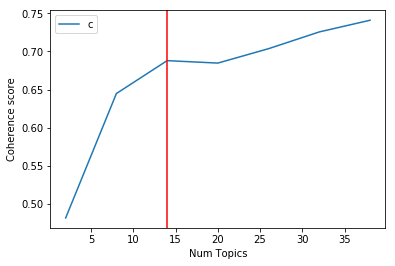

In [108]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=14, color='r')
plt.show()

In [109]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =",m," has Coherence Value of", round(cv,4))

Num Topics = 2  has Coherence Value of 0.4817
Num Topics = 8  has Coherence Value of 0.6448
Num Topics = 14  has Coherence Value of 0.6879
Num Topics = 20  has Coherence Value of 0.6847
Num Topics = 26  has Coherence Value of 0.7036
Num Topics = 32  has Coherence Value of 0.7256
Num Topics = 38  has Coherence Value of 0.7409


In [110]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.404*"coronavirus" + 0.056*"close" + 0.028*"downgrade" + '
  '0.028*"confidence" + 0.028*"afl" + 0.022*"bad" + 0.022*"fear" + '
  '0.022*"income" + 0.017*"subsidy" + 0.017*"restart"'),
 (1,
  '0.176*"cba" + 0.157*"nab" + 0.049*"show" + 0.034*"month" + 0.034*"economy" '
  '+ 0.029*"increase" + 0.025*"property" + 0.020*"tumble" + 0.020*"level" + '
  '0.015*"recession"'),
 (2,
  '0.317*"bank" + 0.125*"big" + 0.038*"branch" + 0.029*"force" + '
  '0.029*"commonwealth" + 0.019*"stock" + 0.019*"economist" + 0.019*"spread" + '
  '0.019*"analyst" + 0.014*"hit"'),
 (3,
  '0.323*"coronavirus" + 0.127*"bank" + 0.091*"pandemic" + 0.045*"price" + '
  '0.018*"report" + 0.014*"season" + 0.014*"loss" + 0.009*"play" + '
  '0.009*"ross" + 0.009*"shopper"'),
 (4,
  '0.155*"covid" + 0.119*"mortgage" + 0.068*"payment" + 0.046*"relief" + '
  '0.041*"push" + 0.032*"rise" + 0.027*"put" + 0.027*"rent" + 0.023*"freeze" + '
  '0.018*"predict"'),
 (5,
  '0.135*"australia" + 0.109*"anz" + 0.047*"impact" + 

### Dominant Topic for each Text
---

In [112]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.0816,"cba, nab, show, month, economy, increase, prop...",Business orders crash on coronavirus: CBA index
1,1,3.0,0.0961,"coronavirus, bank, pandemic, price, report, se...","Sydney, Melbourne house prices facing 10 per c..."
2,2,0.0,0.0955,"coronavirus, close, downgrade, confidence, afl...",Hoarding boom is over: CBA says shoppers have ...
3,3,3.0,0.1074,"coronavirus, bank, pandemic, price, report, se...",Coronavirus: CBA report reveals what we’re buy...
4,4,1.0,0.1013,"cba, nab, show, month, economy, increase, prop...",CBA increases coronavirus loan support
5,5,13.0,0.0903,"coronavirus, nab, unemployment, low, pay, majo...","Coronavirus ASX: Coles, BHP Up, CBA, Westpac, ..."
6,6,7.0,0.1015,"business, support, offer, hit, repayment, smal...",CBA to move to minimum repayments next week - ...
7,7,1.0,0.1013,"cba, nab, show, month, economy, increase, prop...",Businesses can 'tread water' for six months: CBA
8,8,12.0,0.1056,"dividend, crisis, virus, shutdown, time, deman...",Commbank's benefit finder tool sees spike in d...
9,9,1.0,0.0932,"cba, nab, show, month, economy, increase, prop...",House Prices to Fall 10pc: CBA
